In [1]:
# gh repo clone abudesai/timeVAE

# Import packages

In [2]:
import sys

sys.path.insert(0, 'D:/Market_Scenario_Generator_Hackathon')

In [3]:

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 500)
from scipy.stats import levy_stable

from datetime import datetime
from scipy.stats import kstest
from scipy.stats import jarque_bera
from arch.unitroot import ADF
from scipy.stats import kurtosis
from scipy.stats import skew
from arch import arch_model

from sklearn.metrics import mean_squared_error as mse

import pickle

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
plt.style.use('classic')


# %config inlinebackend.figure_format = 'svg'

In [4]:
import ml_collections
import copy
import yaml
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from os import path as pt
import pickle
from torch.utils.data import DataLoader, TensorDataset
from src.baselines.base import BaseTrainer
from src.evaluation.summary import full_evaluation
from src.utils import get_experiment_dir, set_seed, init_weights, save_obj, load_obj
from src.evaluation.scores import compute_auc

In [5]:
from IPython import display

import glob
import imageio
import PIL
import tensorflow_probability as tfp
import time

In [6]:
import tensorflow as tf
import keras
from keras import layers

# Data

## Importing

In [7]:
path = 'D:'

In [8]:
training_data = pd.read_pickle(f'{path}/Market_Scenario_Generator_Hackathon/data/training_data.pkl')
training_data = training_data[1800:3000, :, 0:10]
training_label = pd.read_pickle(f'{path}/Market_Scenario_Generator_Hackathon/data/training_label.pkl')
training_label = training_label[1800:3000, :]

valid_data = pd.read_pickle(f'{path}/Market_Scenario_Generator_Hackathon/data/valid_data.pkl')
valid_data = valid_data[1800:3000, :, 0:10]
valid_label = pd.read_pickle(f'{path}/Market_Scenario_Generator_Hackathon/data/valid_label.pkl')
valid_label = valid_label[1800:3000, :]

In [9]:
training_data.shape, training_label.shape, sum(training_label), valid_data.shape, valid_label.shape, sum(valid_label)

((1200, 5, 10),
 (1200, 1),
 array([103], dtype=int64),
 (1200, 5, 10),
 (1200, 1),
 array([129], dtype=int64))

In [10]:
regular_market_data = training_data[(training_label==0).squeeze()]
crisis_market_data = training_data[(training_label==1).squeeze()]

In [11]:
daily_log_return = training_data[:, :, [0, 2, 4, 6, 8]]
daily_vol = training_data[:, :, [1, 3, 5, 7, 9]]

daily_log_return_1 = training_data[:, 0, [0, 2, 4, 6, 8]]
daily_vol_1 = training_data[:, 0, [1, 3, 5, 7, 9]]

daily_log_return_2 = training_data[:, 1, [0, 2, 4, 6, 8]]
daily_vol_2 = training_data[:, 1, [1, 3, 5, 7, 9]]

daily_log_return_3 = training_data[:, 2, [0, 2, 4, 6, 8]]
daily_vol_3 = training_data[:, 2, [1, 3, 5, 7, 9]]

daily_log_return_4 = training_data[:, 3, [0, 2, 4, 6, 8]]
daily_vol_4 = training_data[:, 3, [1, 3, 5, 7, 9]]

daily_log_return_5 = training_data[:, 4, [0, 2, 4, 6, 8]]
daily_vol_5 = training_data[:, 4, [1, 3, 5, 7, 9]]


In [12]:
daily_log_return.shape, daily_vol.shape

((1200, 5, 5), (1200, 5, 5))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


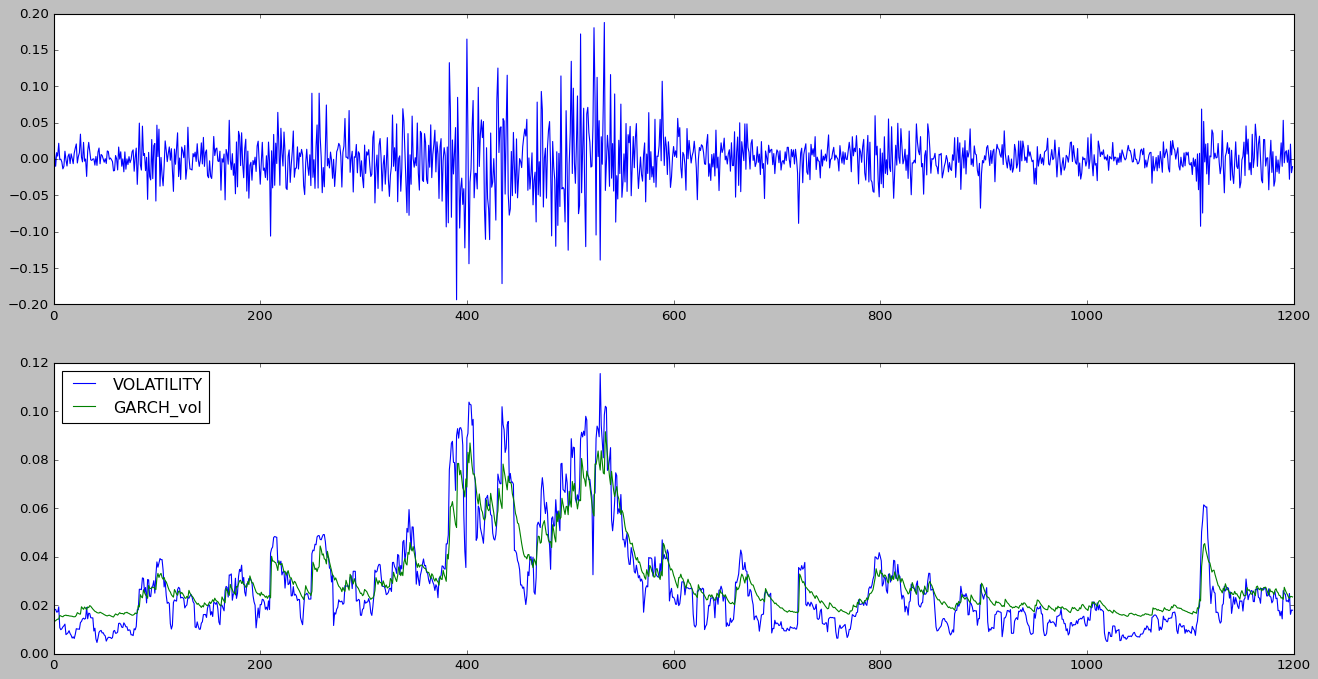

In [13]:
ret = daily_log_return[:, 0, 0]
vol = daily_vol[:, 0, 0]

resids = np.ascontiguousarray(ret)

res_model = arch_model(resids,
                       p = 1,
                       q = 1,
                       mean = 'Zero',
                       vol = 'GARCH',
                       dist = 'normal')

GARCH = res_model.fit(update_freq = 0,
                      disp = 'off')

GARCH_vol = GARCH.conditional_volatility

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))

ax[0].plot(ret, label = f'RET', color = 'blue', linewidth = 1)

ax[1].plot(vol, label = f'VOLATILITY', color = 'blue', linewidth = 1)
ax[1].plot(GARCH_vol, label = f'GARCH_vol', color = 'green', linewidth = 1)

ax[1].legend(loc = 'upper left')

plt.show()

## Visualization

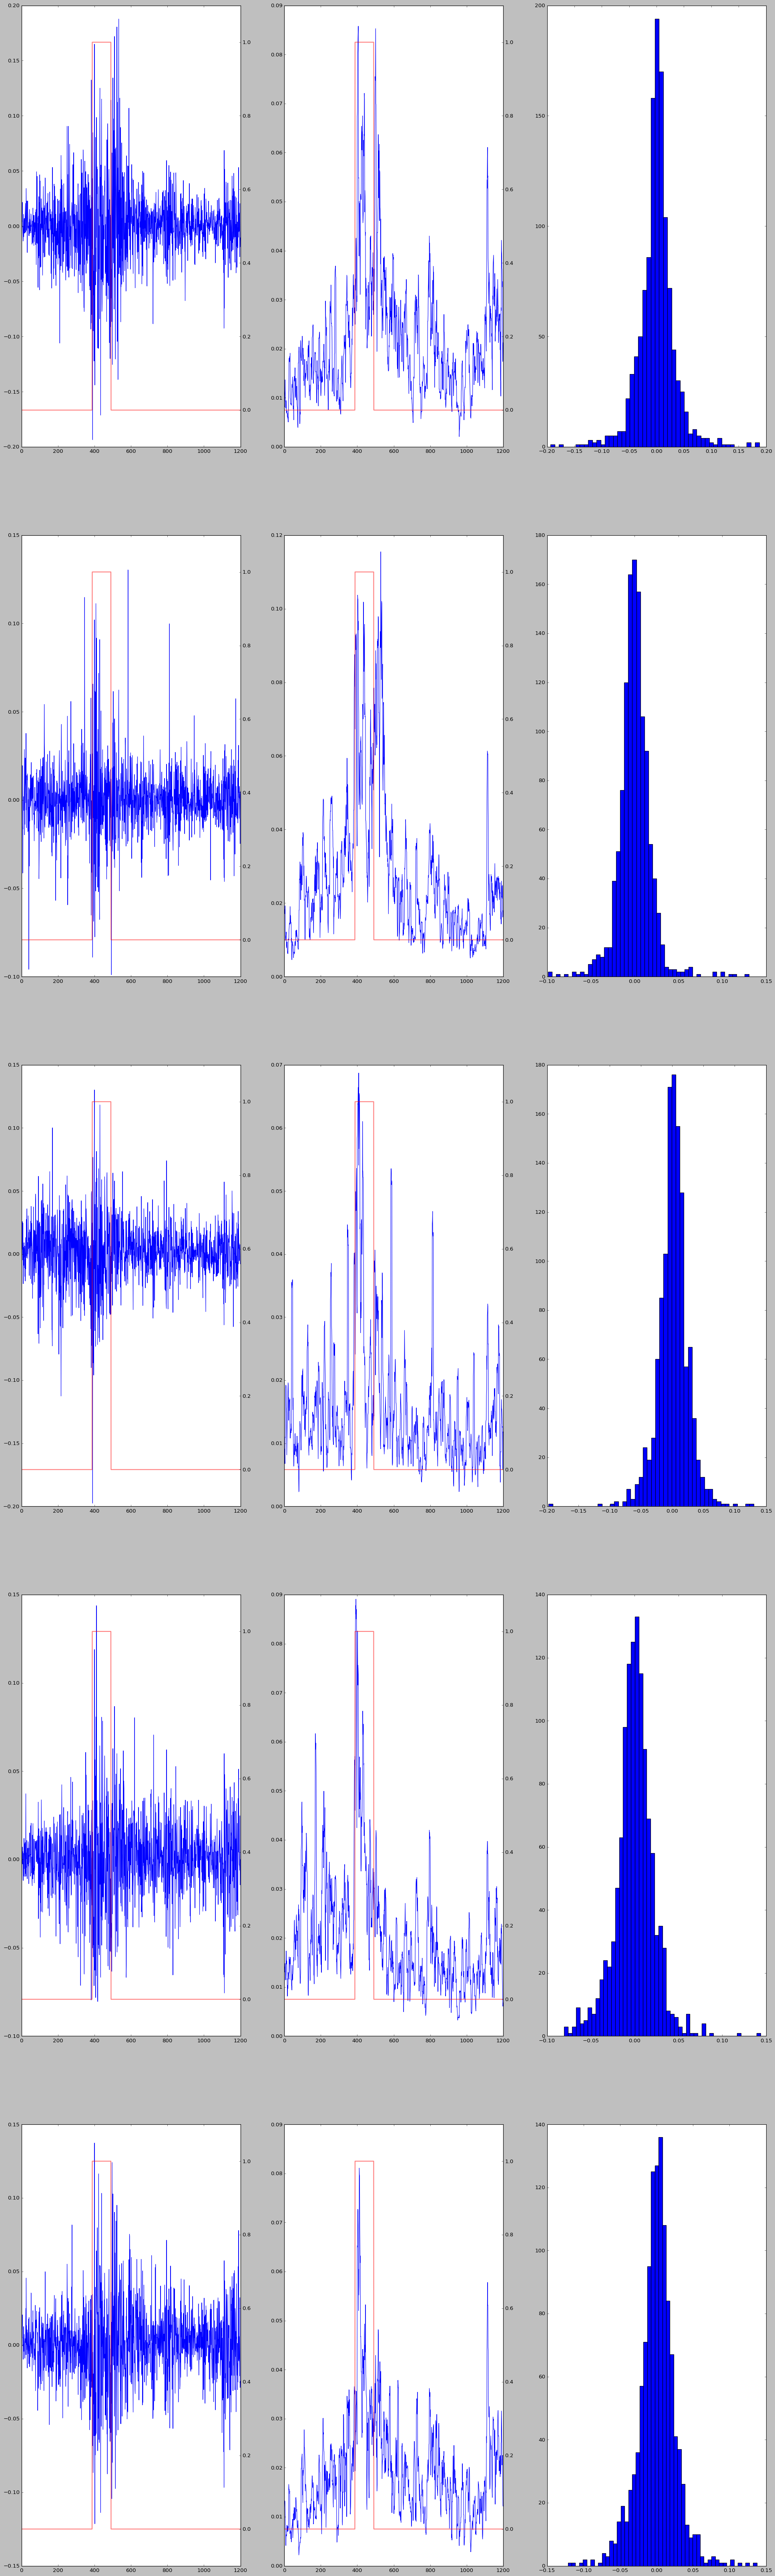

In [14]:
fig, ax = plt.subplots(nrows = 5, ncols = 3, figsize = (30, 100))

for i in range(5):
    ax[i, 0].plot(training_data[:, 0, 2*i], label = f'RET', color = 'blue', linewidth = 1)
    ax2 = ax[i, 0].twinx()
    ax2.plot(training_label, color = 'red', alpha = 0.5, linewidth = 2)
    ax2.set_ylim([-0.1, 1.1])
    # ax[i, 0].legend(loc = 'upper right')

    ax[i, 1].plot(training_data[:, 0, 2*i - 1], label = f'VOLATILITY', color = 'blue', linewidth = 1)
    ax2 = ax[i, 1].twinx()
    ax2.plot(training_label, color = 'red', alpha = 0.5, linewidth = 2)
    ax2.set_ylim([-0.1, 1.1])
    # ax[i, 1].legend(loc = 'upper right')

    ax[i, 2].hist(training_data[:, 0, 2*i], bins = 50)


plt.show()

# Model class

## Conditional_VAE

### Define model

In [15]:
from models.C_VAE_v2 import Sampling, C_VariationalAutoencoder

### Train model

In [16]:

vae = C_VariationalAutoencoder(
    seq_len=5,
    feat_dim = 10,
    latent_dim = 5,
    loss_weight = [3, 2, 2, 1]
)

vae.compile(optimizer=keras.optimizers.Adam(1e-4))


In [17]:
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_curr_input (InputL  [(None, 5, 10)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 flatten (Flatten)           (None, 50)                   0         ['encoder_curr_input[0][0]']  
                                                                                                  
 enc_dense_1 (Dense)         (None, 100)                  5100      ['flatten[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 5)                    505       ['enc_dense_1[0][0]']   

In [18]:
# tf.keras.utils.plot_model(vae.encoder,
#                           #to_file = f'{path}/Data/Structure.png',
#                           dpi = 96,
#                           show_shapes = True,
#                           show_dtype = True,
#                           show_layer_names = True,
#                           show_layer_activations = True,
#                           expand_nested=False,
#                           show_trainable=False)

In [19]:
# tf.keras.utils.plot_model(vae.decoder,
#                           #to_file = f'{path}/Data/Structure.png',
#                           dpi = 96,
#                           show_shapes = True,
#                           show_dtype = True,
#                           show_layer_names = True,
#                           show_layer_activations = True,
#                           expand_nested=False,
#                           show_trainable=False)

In [20]:
batch_size = 32

input_set = tf.data.Dataset.from_tensor_slices((training_data, training_label))
input_set = input_set.batch(batch_size)
dataset = tf.data.Dataset.zip((input_set))
# Initialize the iterator to be passed to the model.fit() function
# data_iter = dataset.make_one_shot_iterator()

In [40]:
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(None, 5, 10), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [21]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)

history = vae.fit(dataset, epochs = 1000, batch_size = batch_size, shuffle = False, verbose = True,
                  callbacks=[callback]
                  )

Epoch 1/1000
38/38 [==============================] - 2s 2ms/step - loss: 734.0174 - reconstruction_loss_1: 226.2535 - reconstruction_loss_2: 21.9299 - reconstruction_loss_3: 0.5252 - kl_loss: 0.0025
Epoch 2/1000
38/38 [==============================] - 0s 1ms/step - loss: 728.7513 - reconstruction_loss_1: 224.5847 - reconstruction_loss_2: 21.8012 - reconstruction_loss_3: 0.4998 - kl_loss: 0.0061
Epoch 3/1000
38/38 [==============================] - 0s 1ms/step - loss: 721.3828 - reconstruction_loss_1: 222.1499 - reconstruction_loss_2: 21.6627 - reconstruction_loss_3: 0.4974 - kl_loss: 0.0180
Epoch 4/1000
38/38 [==============================] - 0s 1ms/step - loss: 709.2948 - reconstruction_loss_1: 218.1695 - reconstruction_loss_2: 21.4041 - reconstruction_loss_3: 0.4913 - kl_loss: 0.0519
Epoch 5/1000
38/38 [==============================] - 0s 1ms/step - loss: 690.9939 - reconstruction_loss_1: 211.9734 - reconstruction_loss_2: 20.9966 - reconstruction_loss_3: 0.5001 - kl_loss: 0.1301


### Evaluation

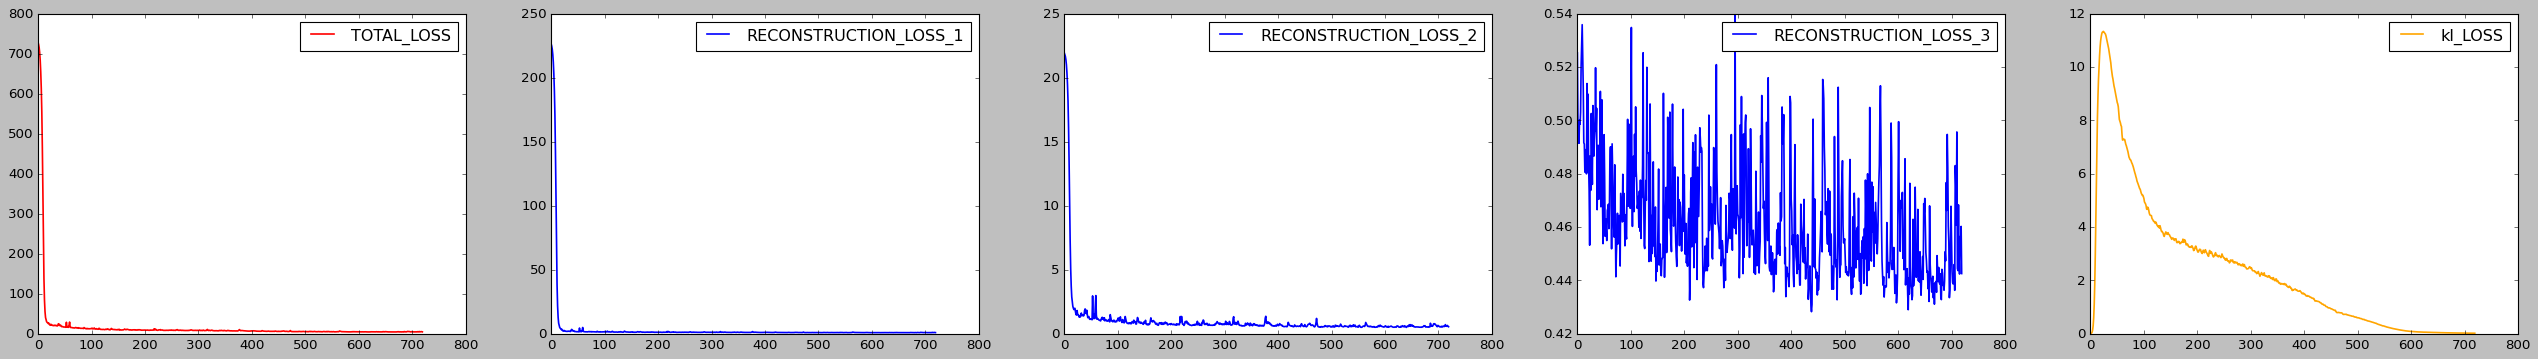

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (40, 5))

ax[0].plot(history.history['loss'], label = f'TOTAL_LOSS', color = 'red', linewidth = 1.5)
ax[0].legend(loc = 'upper right')

ax[1].plot(history.history['reconstruction_loss_1'], label = f'RECONSTRUCTION_LOSS_1', color = 'blue', linewidth = 1.5)
ax[1].legend(loc = 'upper right')

ax[2].plot(history.history['reconstruction_loss_2'], label = f'RECONSTRUCTION_LOSS_2', color = 'blue', linewidth = 1.5)
ax[2].legend(loc = 'upper right')

ax[3].plot(history.history['reconstruction_loss_3'], label = f'RECONSTRUCTION_LOSS_3', color = 'blue', linewidth = 1.5)
ax[3].legend(loc = 'upper right')

ax[4].plot(history.history['kl_loss'], label = f'kl_LOSS', color = 'orange', linewidth = 1.5)
ax[4].legend(loc = 'upper right')

plt.show()

In [23]:
random_fac = tf.random.normal(shape = (200, 5))
# random_fac

In [24]:
regular_conditions = tf.ones(shape = (200, 1))
crisis_conditions = tf.zeros(shape = (200, 1))

In [25]:
# y_regular_pred = vae.decoder.predict([tf.random.normal(shape = (220, 10)), regular_seed])
# y_crisis_pred = vae.decoder.predict([tf.random.normal(shape = (20, 10)), crisis_seed])

regular_fake_data = vae.decoder.predict([random_fac, regular_conditions])
crisis_fake_data = vae.decoder.predict([random_fac, crisis_conditions])


7/7 [==============================] - 0s 834us/step


In [26]:
config_dir = 'src/evaluation/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))


In [27]:
eval_config.device = 'cpu'
eval_config.Evaluation.n_eval = 100
eval_config.Evaluation.metrics_enabled = ['hist_loss',
                                        #   'discriminative_score',
                                        #   'predictive_score',
                                          'acf_loss',
                                          'cov_loss',
                                          'cross_corr',
                                          'var',
                                          'es']

#### In-sample

In [28]:
regular_data = training_data[(training_label==0).squeeze()]
crisis_data = training_data[(training_label==1).squeeze()]

In [29]:
regular_data = torch.tensor(regular_data, dtype = torch.float32)
crisis_data = torch.tensor(crisis_data, dtype = torch.float32)

regular_fake_data = torch.tensor(regular_fake_data)
crisis_fake_data = torch.tensor(crisis_fake_data)

In [30]:
regular_fake_data.shape, crisis_fake_data.shape, regular_data.shape, crisis_data.shape

(torch.Size([200, 5, 10]),
 torch.Size([200, 5, 10]),
 torch.Size([1097, 5, 10]),
 torch.Size([103, 5, 10]))

In [31]:

res_dict_regular = full_evaluation(regular_fake_data, regular_data, eval_config)
# for k, v in res_dict_regular.items():
#     print(k, v)

res_dict_crisis = full_evaluation(crisis_fake_data, crisis_data, eval_config)
# for k, v in res_dict_regular.items():
#     print(k, v)

---- evaluation metric = hist_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:04<00:00, 22.77it/s]


---- evaluation metric = acf_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:01<00:00, 58.68it/s]


---- evaluation metric = cov_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:01<00:00, 65.17it/s]


---- evaluation metric = cross_corr in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:04<00:00, 20.03it/s]


 No metrics enabled in group = implicit_scores
 No metrics enabled in group = sig_scores
 No metrics enabled in group = permutation_test
 No metrics enabled in group = distance_based_metrics
---- evaluation metric = var in group = tail_scores ----


100%|██████████| 100/100 [00:03<00:00, 30.91it/s]


---- evaluation metric = es in group = tail_scores ----


100%|██████████| 100/100 [00:03<00:00, 26.18it/s]


---- evaluation metric = hist_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:01<00:00, 67.00it/s]


---- evaluation metric = acf_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:00<00:00, 180.28it/s]


---- evaluation metric = cov_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:00<00:00, 228.29it/s]


---- evaluation metric = cross_corr in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:01<00:00, 59.97it/s]


 No metrics enabled in group = implicit_scores
 No metrics enabled in group = sig_scores
 No metrics enabled in group = permutation_test
 No metrics enabled in group = distance_based_metrics
---- evaluation metric = var in group = tail_scores ----


100%|██████████| 100/100 [00:01<00:00, 95.01it/s]


---- evaluation metric = es in group = tail_scores ----


100%|██████████| 100/100 [00:01<00:00, 83.76it/s]


In [32]:
df_result = pd.DataFrame.from_dict(res_dict_regular, orient='index')
df_result.columns = ['Regular']
df_result['Crisis'] = res_dict_crisis
df_result['Score'] = 0.7*df_result['Crisis'] + 0.3*df_result['Regular']

df_result

,Regular,Crisis,Score
hist_loss_mean,18.225754,15.904383,16.600794
hist_loss_std,0.312526,0.271516,0.283819
acf_loss_mean,0.326882,0.356917,0.347906
acf_loss_std,0.006007,0.016549,0.013386
cov_loss_mean,0.000039,0.000226,0.000170
cov_loss_std,0.000002,0.000020,0.000015
cross_corr_mean,11.253218,7.658974,8.737247
cross_corr_std,0.170811,0.398854,0.330441
var_mean,0.023405,0.037940,0.033579
var_std,0.005824,0.012202,0.010289


In [33]:
auc = compute_auc(crisis_data, crisis_fake_data, regular_data, regular_fake_data, eval_config)
print(auc)

0.9625


#### Out-of-sample

In [34]:
regular_data = valid_data[(valid_label==0).squeeze()]
crisis_data = valid_data[(valid_label==1).squeeze()]

In [35]:
regular_data = torch.tensor(regular_data, dtype = torch.float32)
crisis_data = torch.tensor(crisis_data, dtype = torch.float32)

regular_fake_data = torch.tensor(regular_fake_data)
crisis_fake_data = torch.tensor(crisis_fake_data)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19280\4243237217.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  regular_fake_data = torch.tensor(regular_fake_data)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19280\4243237217.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  crisis_fake_data = torch.tensor(crisis_fake_data)


In [36]:
regular_fake_data.shape, crisis_fake_data.shape, regular_data.shape, crisis_data.shape

(torch.Size([200, 5, 10]),
 torch.Size([200, 5, 10]),
 torch.Size([1071, 5, 10]),
 torch.Size([129, 5, 10]))

In [37]:

res_dict_regular = full_evaluation(regular_fake_data, regular_data, eval_config)
# for k, v in res_dict_regular.items():
#     print(k, v)

res_dict_crisis = full_evaluation(crisis_fake_data, crisis_data, eval_config)
# for k, v in res_dict_regular.items():
#     print(k, v)

---- evaluation metric = hist_loss in group = stylized_fact_scores ----


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 20.94it/s]


---- evaluation metric = acf_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:01<00:00, 58.52it/s]


---- evaluation metric = cov_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:01<00:00, 62.77it/s]


---- evaluation metric = cross_corr in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:04<00:00, 20.23it/s]


 No metrics enabled in group = implicit_scores
 No metrics enabled in group = sig_scores
 No metrics enabled in group = permutation_test
 No metrics enabled in group = distance_based_metrics
---- evaluation metric = var in group = tail_scores ----


100%|██████████| 100/100 [00:03<00:00, 26.56it/s]


---- evaluation metric = es in group = tail_scores ----


100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


---- evaluation metric = hist_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:01<00:00, 59.17it/s]


---- evaluation metric = acf_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:00<00:00, 160.95it/s]


---- evaluation metric = cov_loss in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:00<00:00, 204.07it/s]


---- evaluation metric = cross_corr in group = stylized_fact_scores ----


100%|██████████| 100/100 [00:02<00:00, 43.26it/s]


 No metrics enabled in group = implicit_scores
 No metrics enabled in group = sig_scores
 No metrics enabled in group = permutation_test
 No metrics enabled in group = distance_based_metrics
---- evaluation metric = var in group = tail_scores ----


100%|██████████| 100/100 [00:01<00:00, 78.08it/s]


---- evaluation metric = es in group = tail_scores ----


100%|██████████| 100/100 [00:01<00:00, 72.11it/s]


In [38]:
df_result = pd.DataFrame.from_dict(res_dict_regular, orient='index')
df_result.columns = ['Regular']
df_result['Crisis'] = res_dict_crisis
df_result['Score'] = 0.7*df_result['Crisis'] + 0.3*df_result['Regular']

df_result.round(5)

,Regular,Crisis,Score
hist_loss_mean,24.58902,12.33960,16.01442
hist_loss_std,0.22025,0.35870,0.31716
acf_loss_mean,0.34934,0.33468,0.33908
acf_loss_std,0.00613,0.01478,0.01219
cov_loss_mean,0.00002,0.00032,0.00023
cov_loss_std,0.00000,0.00005,0.00003
cross_corr_mean,12.89461,7.07746,8.82260
cross_corr_std,0.14832,0.52372,0.41110
var_mean,0.02150,0.03105,0.02818
var_std,0.00475,0.01872,0.01453


In [39]:
auc = compute_auc(crisis_data, crisis_fake_data, regular_data, regular_fake_data, eval_config)
print(auc)

1.0


## GAN

### Define model

### Train model

### Evaluation

#### In-sample

#### Out-of-sample